<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit

from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from feature_engine.selection import DropCorrelatedFeatures

from imblearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

Загружаем и осматриваем данные

In [2]:
data = pd.read_csv('/datasets/taxi.csv')

display(data.head())
print(data.info())

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None


Имеем датафрейм с 26496 объектами и 2 колонками: датой и количеством заказов. 

Сделаем колонку с датой индексом

In [3]:
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace = True)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим монотонность индекса

In [5]:
data.index.is_monotonic

True

Выполним ресемплирование

In [6]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод:**

Данные подготовлены

## Анализ

Проанализируем данные

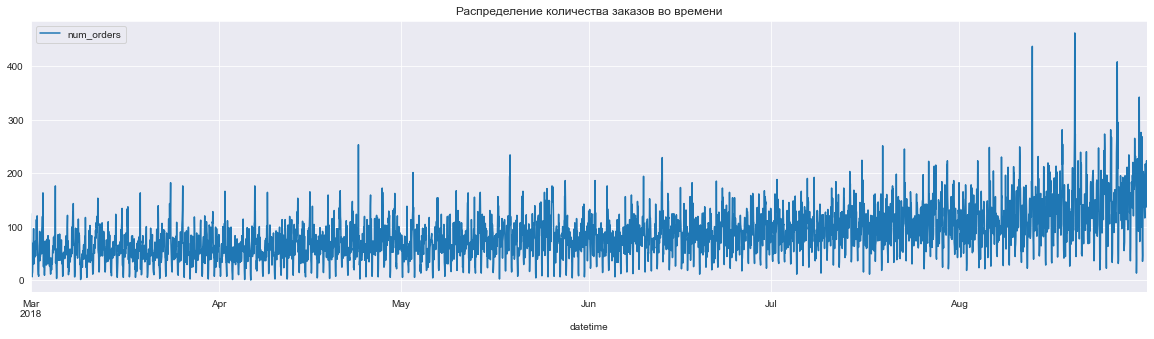

In [7]:
data.plot(figsize = (20,5))
plt.title('Распределение количества заказов во времени')
plt.show()

Временной ряд начинаетмя с марта 2018 и заканчивается августом 2018.

Сгладим данные, посмотрим на скользящее среднее (в 2 дня)

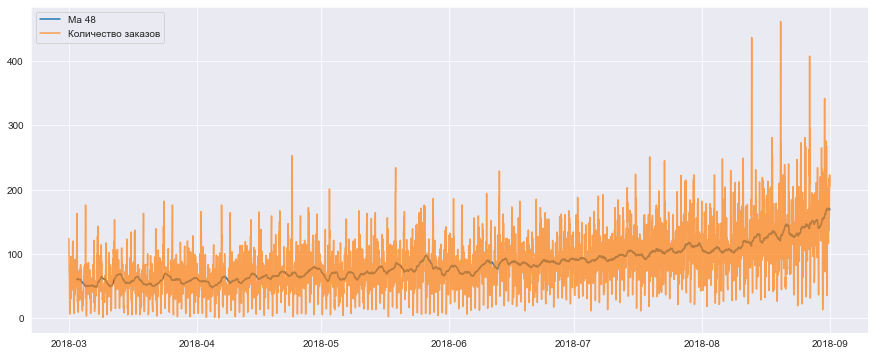

In [8]:
plt.figure(figsize = (15,6))
plt.plot(data.rolling(48).mean())
plt.plot(data, alpha = 0.7)
plt.legend(['Ma 48','Количество заказов'])
plt.show()

In [9]:
st_test = adfuller(data['num_orders'], regression='ctt')

print('adf: ', st_test[0])
print('p-value: ', st_test[1])
print('Critical values: ', st_test[4])

adf:  -10.891452237576233
p-value:  4.0549397928304076e-17
Critical values:  {'1%': -4.373775161444573, '5%': -3.8337377543683258, '10%': -3.554095038926073}


Не только с лета, количество заказов плавно растет с самого начала графика.

Посмотрим тренды и сезонность ресемплированных данных

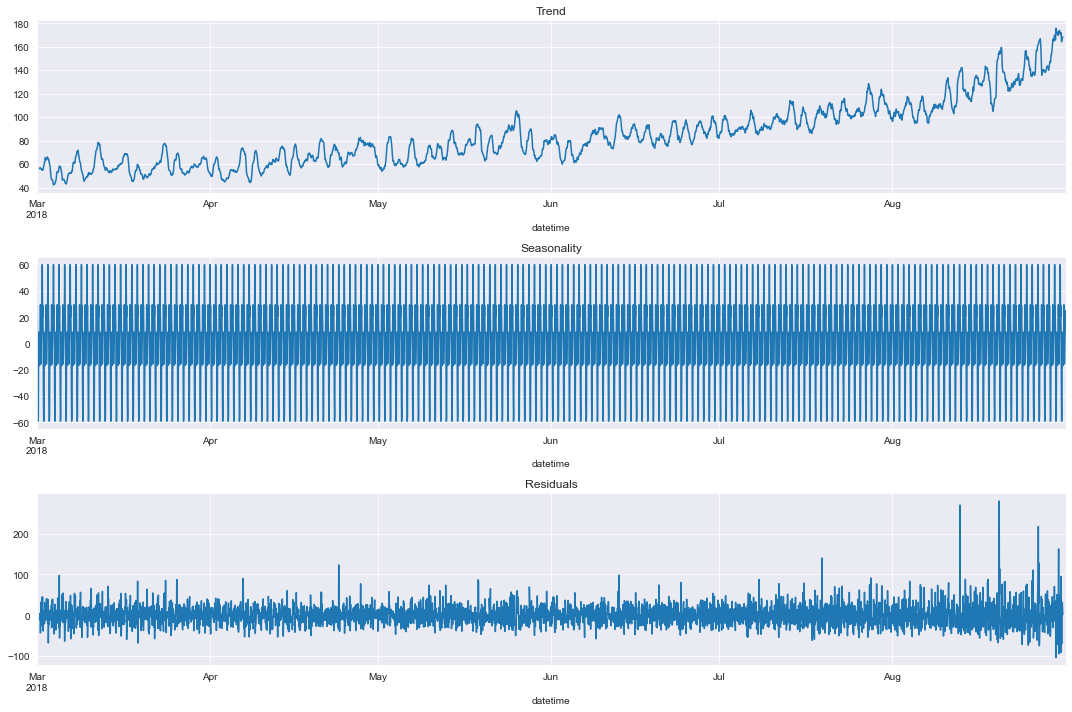

In [10]:
decomposed = seasonal_decompose(data) # < напишите код здесь >

plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.trend.plot()
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot()
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot()
plt.title('Residuals')
plt.tight_layout()

Тренд явно движется вверх. Взглянем ближе на сезонность

Text(0.5, 1.0, 'Seasonality')

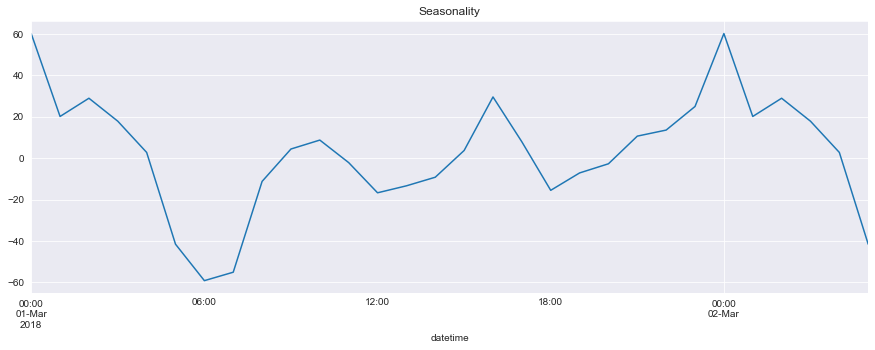

In [11]:
decomposed.seasonal.iloc[0:30].plot(figsize=(15, 5))
plt.title('Seasonality')

Количество поездок уменьшается с полуночи до 6 утра и далее увеличивается.

Оценим изменение стандартного отклонения

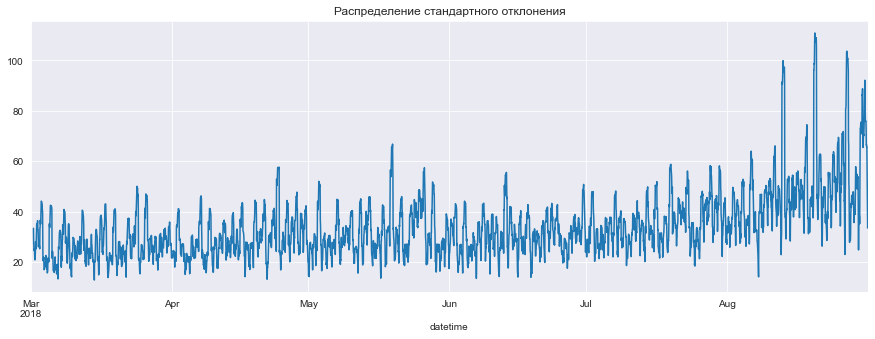

In [12]:
data['num_orders'].rolling(15).std().plot(figsize = (15,5))
plt.title('Распределение стандартного отклонения')
plt.show()

Временной ряд `стационарный`

Данные проанализированы:
- Определены тренд и сезонность
- Временной ряд стационарный

## Обучение

Необходимо спрогнозировать количество заказов. Горизонт прогнозирования - один час

Целевым признаком будет количество заказов. Тренировочными - прошлые данные. Необходимо создать их.

Мы имеем данные за полгода, поэтому в качестве признаков можем выделить:
- `час` - от времени суток зависит сезонность
- `месяц` - от него зависит тренд

Также не лишним будет создать признаки из предыдущих значений временного ряда и скользящего среднего

Напишем функцию, которая будет разбивать данные на выборки.

Аргументы `max_lag`, `rolling_mean_size` будут своеобразными гиперпараметрами

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    df = df.dropna()
    x = df.drop('num_orders', axis = 1)
    y = df['num_orders']
    x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle = False, test_size = 0.1)
    return x_train, x_test, y_train, y_test

C:\Users\Felixalex\miniconda3\envs\practicum\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


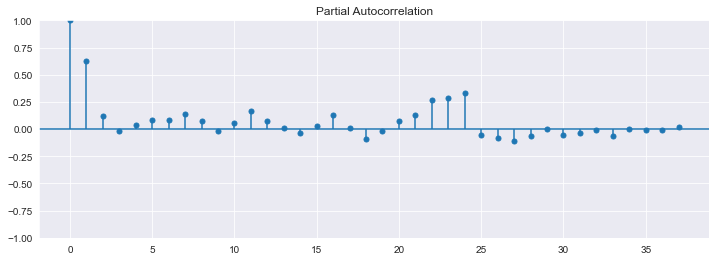

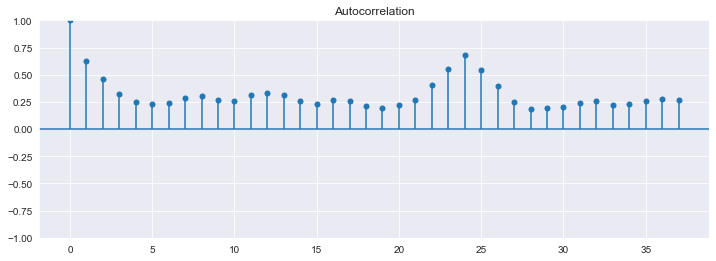

In [14]:
plot_pacf(data, alpha=None).set_size_inches(12, 4)
plt.show()

plot_acf(data, alpha=None).set_size_inches(12, 4)
plt.show()

Проверим ее работу

In [15]:
x_train, x_test, y_train, y_test = make_features(data,5,10)

In [16]:
x_test

,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,
2018-08-13 15:00:00,15,0,102.0,119.0,92.0,144.0,156.0,102.9
2018-08-13 16:00:00,16,0,175.0,102.0,119.0,92.0,144.0,112.1
2018-08-13 17:00:00,17,0,144.0,175.0,102.0,119.0,92.0,119.9
2018-08-13 18:00:00,18,0,152.0,144.0,175.0,102.0,119.0,131.2
2018-08-13 19:00:00,19,0,104.0,152.0,144.0,175.0,102.0,132.5
...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,19,4,207.0,217.0,197.0,116.0,133.0,173.3
2018-08-31 20:00:00,20,4,136.0,207.0,217.0,197.0,116.0,166.6
2018-08-31 21:00:00,21,4,154.0,136.0,207.0,217.0,197.0,162.9


In [17]:
y_train

datetime
2018-03-01 10:00:00     64
2018-03-01 11:00:00     96
2018-03-01 12:00:00     30
2018-03-01 13:00:00     32
2018-03-01 14:00:00     48
                      ... 
2018-08-13 10:00:00    156
2018-08-13 11:00:00    144
2018-08-13 12:00:00     92
2018-08-13 13:00:00    119
2018-08-13 14:00:00    102
Freq: H, Name: num_orders, Length: 3965, dtype: int64

In [18]:
print(y_train.head())
display(x_train.head())
display(data.loc[x_train.index[0]:].head())
print(y_test.head())
display(x_test.head())
display(data.loc[x_test.index[0]:].head())

datetime
2018-03-01 10:00:00    64
2018-03-01 11:00:00    96
2018-03-01 12:00:00    30
2018-03-01 13:00:00    32
2018-03-01 14:00:00    48
Freq: H, Name: num_orders, dtype: int64


,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,
2018-03-01 10:00:00,10,3,69.0,34.0,15.0,12.0,6.0,52.5
2018-03-01 11:00:00,11,3,64.0,69.0,34.0,15.0,12.0,46.5
2018-03-01 12:00:00,12,3,96.0,64.0,69.0,34.0,15.0,47.6
2018-03-01 13:00:00,13,3,30.0,96.0,64.0,69.0,34.0,43.5
2018-03-01 14:00:00,14,3,32.0,30.0,96.0,64.0,69.0,40.1


,num_orders
datetime,
2018-03-01 10:00:00,64
2018-03-01 11:00:00,96
2018-03-01 12:00:00,30
2018-03-01 13:00:00,32
2018-03-01 14:00:00,48


datetime
2018-08-13 15:00:00    175
2018-08-13 16:00:00    144
2018-08-13 17:00:00    152
2018-08-13 18:00:00    104
2018-08-13 19:00:00     91
Freq: H, Name: num_orders, dtype: int64


,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,
2018-08-13 15:00:00,15,0,102.0,119.0,92.0,144.0,156.0,102.9
2018-08-13 16:00:00,16,0,175.0,102.0,119.0,92.0,144.0,112.1
2018-08-13 17:00:00,17,0,144.0,175.0,102.0,119.0,92.0,119.9
2018-08-13 18:00:00,18,0,152.0,144.0,175.0,102.0,119.0,131.2
2018-08-13 19:00:00,19,0,104.0,152.0,144.0,175.0,102.0,132.5


,num_orders
datetime,
2018-08-13 15:00:00,175
2018-08-13 16:00:00,144
2018-08-13 17:00:00,152
2018-08-13 18:00:00,104
2018-08-13 19:00:00,91


Все работает корректно. Данные совпадают, сдвиги верные

Для подбора гиперпараметров моделей будем использовать `RandomizedSearchCV`, а параметры `max_lag`, `rolling_mean_size` переберем в цикле

In [19]:
cat_columns = ['hour']
num_columns = x_train.select_dtypes('float').columns

Запишем функцию для составления пайплайна. Нужно для того, чтобы каждый раз перезаписывать `num_columns`

In [20]:
def new_pipeline(num_columns):
    num_pipeline = Pipeline([('scaler', StandardScaler()),
                             ('drop_correlations', DropCorrelatedFeatures())])

    columns_pipeline = ColumnTransformer([('num_cols', num_pipeline, num_columns),
                                          ('cat_encoder', OneHotEncoder(drop = 'first', handle_unknown='ignore'), cat_columns)])

    pipeline = make_pipeline(columns_pipeline)
    pipeline.steps.append(('regressor', DummyRegressor()))
    return pipeline

Проверим работу модели на дамми-регрессоре

In [21]:
params = [
    {
    'regressor': [DummyRegressor()],
    'regressor__strategy': ['mean', 'median']    
    }
]

In [22]:
tscv = TimeSeriesSplit(n_splits=3)

In [23]:
best_result = -50
for max_lag in range(1,10):
    for ma in [5,10]:
        x_train, x_test, y_train, y_test = make_features(data,max_lag,ma)
        num_columns = x_train.select_dtypes('float').columns       

        pipeline = new_pipeline(num_columns)
        
        grid_model_dummy = GridSearchCV(pipeline, params, cv = tscv, scoring = 'neg_root_mean_squared_error', n_jobs = -1)
        grid_model_dummy.fit(x_train, y_train)
        
        if grid_model_dummy.best_score_ > best_result:
            best_result = grid_model_dummy.best_score_
            best_ma = ma
            best_lag = max_lag
            best_model_dummy = grid_model_dummy
            
        print(f'max_lag = {max_lag}, ma = {ma},{grid_model_dummy.best_params_}, {- grid_model_dummy.best_score_}')
print(f'Лучший результат \nRMSE {-best_result}, параметры max_lag = {best_lag}, ma = {best_ma}, {grid_model_dummy.best_params_}')

max_lag = 1, ma = 5,{'regressor': DummyRegressor(), 'regressor__strategy': 'mean'}, 42.62136684543324
max_lag = 1, ma = 10,{'regressor': DummyRegressor(), 'regressor__strategy': 'mean'}, 42.59064206830353
max_lag = 2, ma = 5,{'regressor': DummyRegressor(), 'regressor__strategy': 'mean'}, 42.62136684543324
max_lag = 2, ma = 10,{'regressor': DummyRegressor(), 'regressor__strategy': 'mean'}, 42.59064206830353
max_lag = 3, ma = 5,{'regressor': DummyRegressor(), 'regressor__strategy': 'mean'}, 42.62136684543324
max_lag = 3, ma = 10,{'regressor': DummyRegressor(), 'regressor__strategy': 'mean'}, 42.59064206830353
max_lag = 4, ma = 5,{'regressor': DummyRegressor(), 'regressor__strategy': 'mean'}, 42.62136684543324
max_lag = 4, ma = 10,{'regressor': DummyRegressor(), 'regressor__strategy': 'mean'}, 42.59064206830353
max_lag = 5, ma = 5,{'regressor': DummyRegressor(), 'regressor__strategy': 'mean'}, 42.62136684543324
max_lag = 5, ma = 10,{'regressor': DummyRegressor(), 'regressor__strategy': 'm

Заполняем средним и RMSE равно 42 - успех, заказчик требовал всего 48. Отдаем дамми-модель в продакшн?

Получилась почти совершенная модель, но проверим еще несколько. Сначала линейная регрессия. Создадим список параметров

In [24]:
params = [
    {
    'regressor': [LinearRegression()],
    'regressor__fit_intercept': [True, False]    
    }
]

In [25]:
best_result = -50
for max_lag in range(1,25):
    for ma in [5,10]:
        x_train, x_test, y_train, y_test = make_features(data,max_lag,ma)
        num_columns = x_train.select_dtypes('float').columns       

        pipeline = new_pipeline(num_columns)
        grid_model_lr = GridSearchCV(pipeline, params, cv = tscv, scoring = 'neg_root_mean_squared_error', n_jobs = -1)
        grid_model_lr.fit(x_train, y_train)
        
        if grid_model_lr.best_score_ > best_result:
            best_result = grid_model_lr.best_score_
            best_ma = ma
            best_lag = max_lag
            best_params = grid_model_lr.best_params_
            best_model_lr = grid_model_lr
        print(f'max_lag = {max_lag}, ma = {ma},{grid_model_lr.best_params_}, {- grid_model_lr.best_score_}')
print(f'Лучший результат \nRMSE {-best_result}, параметры max_lag = {best_lag}, ma = {best_ma}, {grid_model_lr.best_params_}')

max_lag = 1, ma = 5,{'regressor': LinearRegression(), 'regressor__fit_intercept': True}, 27.82480418055327
max_lag = 1, ma = 10,{'regressor': LinearRegression(), 'regressor__fit_intercept': True}, 27.25939310535723
max_lag = 2, ma = 5,{'regressor': LinearRegression(), 'regressor__fit_intercept': True}, 27.790756002609854
max_lag = 2, ma = 10,{'regressor': LinearRegression(), 'regressor__fit_intercept': True}, 27.173794867840627
max_lag = 3, ma = 5,{'regressor': LinearRegression(), 'regressor__fit_intercept': True}, 27.806825964430555
max_lag = 3, ma = 10,{'regressor': LinearRegression(), 'regressor__fit_intercept': True}, 27.207684358054678
max_lag = 4, ma = 5,{'regressor': LinearRegression(), 'regressor__fit_intercept': True}, 27.82462098459651
max_lag = 4, ma = 10,{'regressor': LinearRegression(), 'regressor__fit_intercept': True}, 27.247241532752742
max_lag = 5, ma = 5,{'regressor': LinearRegression(), 'regressor__fit_intercept': True}, 27.82461576792238
max_lag = 5, ma = 10,{'regre

Уже лучше. RMSE 26.39

Случайный лес

In [26]:
params = [
    {
    'regressor': [RandomForestRegressor(random_state = 12345)],
    'regressor__max_depth': range(2,20),
    'regressor__n_estimators': range(10,100),
    'regressor__min_samples_split': range(2,5)
    }
]

In [27]:
best_result = -50
for max_lag in range(1,10):
    for ma in [5,10]:
        x_train, x_test, y_train, y_test = make_features(data,max_lag,ma)
        num_columns = x_train.select_dtypes('float').columns       

        pipeline = new_pipeline(num_columns)
        grid_model_rfr = RandomizedSearchCV(pipeline, params, n_iter=10, cv = tscv, scoring = 'neg_root_mean_squared_error', n_jobs = -1)
        grid_model_rfr.fit(x_train, y_train)
        
        if grid_model_rfr.best_score_ > best_result:
            best_result = grid_model_rfr.best_score_
            best_ma = ma
            best_lag = max_lag
            best_params = grid_model_rfr.best_params_
            best_model_rfr = grid_model_rfr
        print(f'max_lag = {max_lag}, ma = {ma},{grid_model_rfr.best_params_}, {- grid_model_rfr.best_score_}')
        print()
print(f'Лучший результат \nRMSE {-best_result}, параметры max_lag = {best_lag}, ma = {best_ma}, {best_params}')

max_lag = 1, ma = 5,{'regressor__n_estimators': 99, 'regressor__min_samples_split': 4, 'regressor__max_depth': 11, 'regressor': RandomForestRegressor(max_depth=11, min_samples_split=4, n_estimators=99,
                      random_state=12345)}, 30.626792369927767

max_lag = 1, ma = 10,{'regressor__n_estimators': 92, 'regressor__min_samples_split': 3, 'regressor__max_depth': 9, 'regressor': RandomForestRegressor(max_depth=9, min_samples_split=3, n_estimators=92,
                      random_state=12345)}, 29.638682598937688

max_lag = 2, ma = 5,{'regressor__n_estimators': 92, 'regressor__min_samples_split': 2, 'regressor__max_depth': 12, 'regressor': RandomForestRegressor(max_depth=12, n_estimators=92, random_state=12345)}, 30.414165227610074

max_lag = 2, ma = 10,{'regressor__n_estimators': 73, 'regressor__min_samples_split': 4, 'regressor__max_depth': 10, 'regressor': RandomForestRegressor(max_depth=10, min_samples_split=4, n_estimators=73,
                      random_state=12345)},

Случайный лес долго разрастался до огромных величин, но так и не смог побить результат обычной линейной регрессии

In [28]:
params = [
    {
    'regressor': [lgb.LGBMRegressor(random_state = 12345)],
    'regressor__max_depth': range(5,20),
    'regressor__n_estimators': range(50,500),
    'regressor__num_leaves': range(10,100)
    }
]

In [29]:
best_result = -50
for max_lag in range(1,10):
    for ma in [5,10]:
        x_train, x_test, y_train, y_test = make_features(data,max_lag,ma)
        num_columns = x_train.select_dtypes('float').columns       

        pipeline = new_pipeline(num_columns)
        grid_model_lgb = RandomizedSearchCV(pipeline, params, n_iter=20, cv = tscv, scoring = 'neg_root_mean_squared_error', n_jobs = -1)
        grid_model_lgb.fit(x_train, y_train)
        
        if grid_model_lgb.best_score_ > best_result:
            best_result = grid_model_lgb.best_score_
            best_ma = ma
            best_lag = max_lag
            best_params = grid_model_lgb.best_params_
            best_model_lgb = grid_model_lgb
        print(f'max_lag = {max_lag}, ma = {ma},{grid_model_lgb.best_params_}, {- grid_model_lgb.best_score_}')
        print()
print(f'Лучший результат \nRMSE {-best_result}, параметры max_lag = {best_lag}, ma = {best_ma}, {best_params}')

max_lag = 1, ma = 5,{'regressor__num_leaves': 12, 'regressor__n_estimators': 107, 'regressor__max_depth': 5, 'regressor': LGBMRegressor(max_depth=5, n_estimators=107, num_leaves=12, random_state=12345)}, 29.625444303882546

max_lag = 1, ma = 10,{'regressor__num_leaves': 10, 'regressor__n_estimators': 451, 'regressor__max_depth': 11, 'regressor': LGBMRegressor(max_depth=11, n_estimators=451, num_leaves=10, random_state=12345)}, 29.310871953520742

max_lag = 2, ma = 5,{'regressor__num_leaves': 35, 'regressor__n_estimators': 248, 'regressor__max_depth': 5, 'regressor': LGBMRegressor(max_depth=5, n_estimators=248, num_leaves=35, random_state=12345)}, 29.813399777569483

max_lag = 2, ma = 10,{'regressor__num_leaves': 11, 'regressor__n_estimators': 121, 'regressor__max_depth': 5, 'regressor': LGBMRegressor(max_depth=5, n_estimators=121, num_leaves=11, random_state=12345)}, 28.872726472472678

max_lag = 3, ma = 5,{'regressor__num_leaves': 13, 'regressor__n_estimators': 331, 'regressor__max_de

**Вывод:**

Крутые модели от `Microsoft` - ничто, линеечка - все

## Тестирование

Тестируем модель. Необходимо сделать те же признаки, что были в лучшей модели

In [30]:
x_train, x_test, y_train, y_test = make_features(data,24,10)
num_columns = x_train.select_dtypes('float').columns

In [31]:
preds = best_model_lr.predict(x_test)
mean_squared_error(y_test, preds) ** 0.5

42.20686104635001

RMSE на тестовой выборке 42,21. Успех

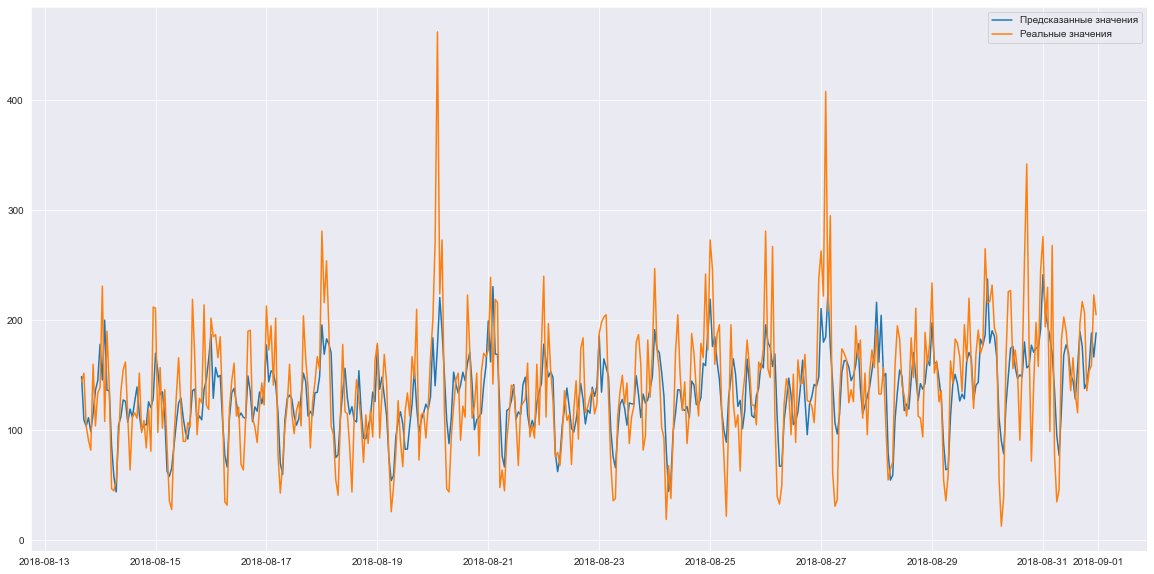

In [32]:
preds = pd.DataFrame(preds, index = y_test.index)
plt.figure(figsize = (20,10))
plt.plot(preds)
plt.plot(y_test)
plt.legend(['Предсказанные значения','Реальные значения'])
plt.show()

Пики модель предсказывает, но все равно предсказания более "сглаженные", чем реальность. Возможно, если метрикой был бы не чувствительный к выбросам RMSE, то лучшей моделью оказалась бы другая

### Общий вывод

Задачей исследования являлось построение модели для прогнозирования количества заказов такси в аэропортах.
Были исследованы данные и построены модели Линейной регрессии, Случайного леса и LBGMRegressor

Лучшей моделью оказалась Линейная регрессия, с метрикой RMSE на тестовой выборке 7.35